In [1]:
import warnings
warnings.filterwarnings('ignore')

from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *

In [2]:
data_path = Path('./chest_xray').absolute()
model_path = Path('./model').absolute()

In [3]:
sz = 456
lr = 0.003 * torch.cuda.device_count()
bs = 64 * torch.cuda.device_count()

In [4]:
stats = ([0.48746821, 0.48746821, 0.48746821], [0.24557937, 0.24557937, 0.24557937])

def valid_func(o):
    return 'test' in str(o)

def label_func(o):
    name = o.name
    if 'virus' in name:
        return 'virus'
    if 'bacteria' in name:
        return 'bacteria'
    return 'normal'

data = (ImageList.from_folder(data_path)
        .split_by_valid_func(valid_func)
        .label_from_func(label_func)
        .transform(get_transforms(), size=sz)
        .databunch(bs=bs)
        .normalize(stats)
        )

data, data.classes

(ImageDataBunch;
 
 Train: LabelList (5232 items)
 x: ImageList
 Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
 y: CategoryList
 normal,normal,normal,normal,normal
 Path: /media/sm2/data/pneumonia/chest_xray;
 
 Valid: LabelList (624 items)
 x: ImageList
 Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
 y: CategoryList
 normal,normal,normal,normal,normal
 Path: /media/sm2/data/pneumonia/chest_xray;
 
 Test: None,
 ['bacteria', 'normal', 'virus'])

In [5]:
learn = cnn_learner(data, 
                    models.resnet50,
                    bn_wd=False,
                    metrics=error_rate,
                    loss_func=LabelSmoothingCrossEntropy(),
                    callback_fns=[BnFreeze,
                                  partial(SaveModelCallback, monitor='error_rate', name='best_error')
                                 ],
                   ).to_fp16()

In [6]:
learn.to_parallel();

In [7]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,error_rate,time
0,1.155060,1.762327,0.512821,01:13
1,0.897903,0.770776,0.200321,01:11
2,0.754491,0.610552,0.165064,01:10
3,0.683952,0.600679,0.141026,01:10
4,0.638181,0.621511,0.155449,01:10


Better model found at epoch 0 with error_rate value: 0.5128205418586731.
Better model found at epoch 1 with error_rate value: 0.2003205120563507.
Better model found at epoch 2 with error_rate value: 0.16506409645080566.
Better model found at epoch 3 with error_rate value: 0.1410256326198578.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 6.31E-08


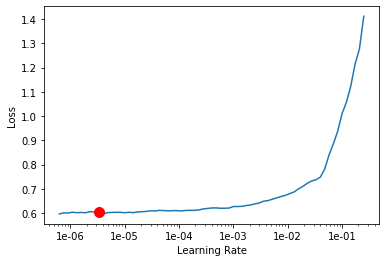

In [8]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [9]:
lr = 1e-4
learn.fit_one_cycle(5, slice(lr/40, lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.608496,0.590216,0.142628,01:13
1,0.598999,0.602620,0.152244,01:12
2,0.594643,0.604624,0.137821,01:11
3,0.581948,0.601473,0.139423,01:10
4,0.574475,0.592355,0.141026,01:12


Better model found at epoch 0 with error_rate value: 0.14262819290161133.
Better model found at epoch 2 with error_rate value: 0.1378205120563507.


In [10]:
interp = ClassificationInterpretation.from_learner(learn)

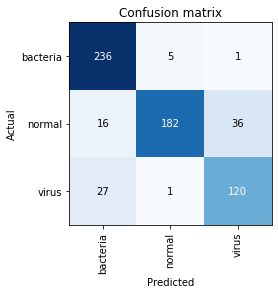

In [11]:
interp.plot_confusion_matrix()